<a href="https://colab.research.google.com/github/KaipoCraft/mapGAN/blob/main/low_res_model2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Project: mapGAN

##Melanie Sharif & Neill Shikada
###INFO 5604 / Applied Machine Learning
###Dr. Robin Burke

# 1. Import Dependencies

Basic ML packages

In [70]:
import scipy as sp
import pandas as pd
import numpy as np

Visualization packages

In [71]:
import matplotlib.pyplot as plt
import seaborn as sb


Tensorflow

In [72]:
import tensorflow as tf

In [73]:
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam, SGD

Other packages for loading bars, time estimations, file paths, and image downloading & tweaking

In [74]:
from PIL import Image
from tqdm import tqdm
import os 
import time
from google.colab import drive

We'll be using primarily TensorFlow to create our DCGAN

# 2. Data

In [75]:
#mount Google Drive and create a data path
drive.mount('/content/drive')
DATA_PATH = '/content/drive/MyDrive/mapGAN8/Industrial'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2.1 Input Data Setup

In [76]:
#image resolution factor
# (1=32, 2=64, 3=96, 4=128, etc.)
GENERATE_RES = 4

#image size (in pixels)
#rows/cols (should be square)
GENERATE_SQUARE = 32 * GENERATE_RES 

#color channels
#a val of 4 would include alpha
IMAGE_CHANNELS = 3

print(f"The model will generate {GENERATE_SQUARE}px square images.")

The model will generate 128px square images.


##2.2 Input Data Preprocessing

In [77]:
#preprocessing timer
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


In [78]:
#location of the preprocessed data in Drive
training_pp_path = os.path.join(DATA_PATH,
        f'training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy')


The block below checks to see if the input data has been preprocessed yet. 

If it has, it loads the last-used training pickle as the training data.

If it hasn't, it creates an array for the training data, and loads the images from the specified path in Drive. Then it resizes each image into a square of a size we specified (currently 64px) and adds each file (as `Image` objects) from that path into an `np.array`.

The data is then reshaped to include RGB channels, and finally normalized

In [79]:
print(f"Looking for file: {training_pp_path}")

if not os.path.isfile(training_pp_path):
  start = time.time()
  print("Loading training images...")

  training_data = []
  GIS_path = os.path.join(DATA_PATH)
 
  for filename in tqdm(os.listdir(GIS_path)):
      path = os.path.join(GIS_path,filename)
      image = Image.open(path).resize((GENERATE_SQUARE,
            GENERATE_SQUARE)) #removed an Image.ANTIALIAS filter from here
      training_data.append(np.asarray(image))
  
  training_data = np.reshape(training_data,(-1,GENERATE_SQUARE,
            GENERATE_SQUARE,IMAGE_CHANNELS))
  
  training_data = training_data.astype(np.float32)
  training_data = training_data / 255.0 

  print("Saving preprocessed data...")
  
  #this function saves the pickle, and saves the file to Drive
  np.save(training_pp_path,training_data)
  elapsed = time.time()-start
  print (f'Image preprocess time: {hms_string(elapsed)}')

else:
  print("Loading previous training pickle...")
  training_data = np.load(training_pp_path)

Looking for file: /content/drive/MyDrive/mapGAN8/Industrial/training_data_128_128.npy
Loading training images...


100%|██████████| 1250/1250 [00:01<00:00, 807.85it/s]


Saving preprocessed data...
Image preprocess time: 0:00:02.08


## 2.3 Output Data Setup

In [80]:
# output data preview
PREVIEW_ROWS = 2
PREVIEW_COLS = 2
PREVIEW_MARGIN = 16


In [81]:
#batch and buffer size for shuffling
BATCH_SIZE = 32
BUFFER_SIZE = 60000

#shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(training_data) \
    .shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

This block below is a function to save all training output images to Drive.

In [82]:
def save_images(cnt,noise):
  image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 3), 
      255, dtype=np.uint8)
  
  generated_images = generator.predict(noise)

  generated_images = 0.5 * generated_images + 0.5

  image_count = 0

  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] \
            = generated_images[image_count] * 255
        image_count += 1
          
  output_path = os.path.join(DATA_PATH,'output')
  if not os.path.exists(output_path):
    os.makedirs(output_path)
  
  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)

# 3. Build Neural Networks

## 3.2 Build Generator

First we define the function to build the generator, a CNN. 

The activation function is ReLu for all layers except for the output, which uses Tanh. The use of bounded activation was shown to be a stable architecture choice (citation: [https://arxiv.org/pdf/1511.06434.pdf])

In [83]:
#building the generator
def build_generator(seed_size, channels):
    model = Sequential()

    model.add(Dense(4*4*256,activation="relu",input_dim=seed_size))
    model.add(Reshape((4,4,256)))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
   
    # Output resolution, additional upsampling
    model.add(UpSampling2D())
    model.add(Conv2D(128,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    if GENERATE_RES>1:
      model.add(UpSampling2D(size=(GENERATE_RES,GENERATE_RES)))
      model.add(Conv2D(128,kernel_size=3,padding="same"))
      model.add(BatchNormalization(momentum=0.8))
      model.add(Activation("relu"))

    # Final CNN layer
    model.add(Conv2D(channels,kernel_size=3,padding="same"))
    model.add(Activation("tanh"))

    return model

## 3.3 Build Discriminator

Next we define the function to build the discriminator, another CNN. 

The activation function is LeakyReLu for all layers. This was shown to be a stable & effective arch. choice for DCGANs (citation: [https://arxiv.org/pdf/1511.06434.pdf])

In [84]:
#building the discriminator
def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, 
                     padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

# 4. Training

In [85]:
#specify the number of epochs
EPOCHS = 200

#Size of random noise vector to generate images from
SEED_SIZE = 100

Instantiate the generator, create the seed noise and test the generator 

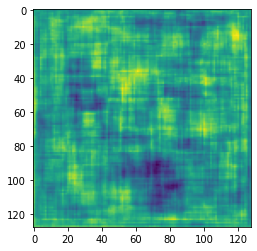

In [86]:
generator = build_generator(SEED_SIZE, IMAGE_CHANNELS)

noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

Instantiate the driscriminator and print a test decision

In [87]:
image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)

discriminator = build_discriminator(image_shape)
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.49960512]], shape=(1, 1), dtype=float32)


We'll use `BinaryCrossentropy`

In [88]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

In [89]:
#discriminator loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

#generator loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

We experimented with using `SGD` as the optimizer, but it greatly increased loss

In [90]:
#generator_optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
#discriminator_optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

Using `Adam` as the optimizer instead as this was also shown to increase stability in the model's training process. `Adam` uses as an adaptive learning rate, which improves performance

In [91]:
generator_optimizer = tf.keras.optimizers.Adam(.0002,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(.0002,0.5)

In [92]:
#from https://www.tensorflow.org/tutorials/generative/dcgan
#using pre-compiling
@tf.function
def train_step(images):
  seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(seed, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(\
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(\
        disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(
        gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(
        gradients_of_discriminator, 
        discriminator.trainable_variables))
  return gen_loss,disc_loss

In [93]:
#training 
def train(dataset, epochs):
  fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, 
                                       SEED_SIZE))
  start = time.time()

  for epoch in range(epochs):
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    for image_batch in dataset:
      t = train_step(image_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])

    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    epoch_elapsed = time.time()-epoch_start
    print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss},'\
           ' {hms_string(epoch_elapsed)}')
    save_images(epoch,fixed_seed)

  elapsed = time.time()-start
  print (f'Training time: {hms_string(elapsed)}')

train(train_dataset, EPOCHS)

Epoch 1, gen loss=3.562763214111328,disc loss=1.830130934715271, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 166ms/step
Epoch 2, gen loss=8.294474601745605,disc loss=1.8415744304656982, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 17ms/step
Epoch 3, gen loss=8.508914947509766,disc loss=0.7619267702102661, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 17ms/step
Epoch 4, gen loss=9.019830703735352,disc loss=0.7084376215934753, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 17ms/step
Epoch 5, gen loss=11.07565689086914,disc loss=1.2882561683654785, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 17ms/step
Epoch 6, gen loss=5.534154415130615,disc loss=1.484967827796936, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 17ms/step
Epoch 7, gen loss=2.8059675693511963,disc loss=1.83974289894104, {hms_string(epoch_elapsed)}
1/1 [===========================